# وارد کردن کتابخانه ها

In [ ]:
# کتابخانه‌های موردنیاز
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor



# بارگیری داده

In [ ]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

# بارگیری داده‌ها
data = fetch_california_housing()
X, y = data.data, data.target

# تبدیل به DataFrame برای مشاهده اولیه
columns = data.feature_names
housing_df = pd.DataFrame(X, columns=columns)
housing_df['Target'] = y  # اضافه کردن متغیر هدف

# نمایش 5 نمونه اول برای بررسی
print("Sample Data:")
print(housing_df.head())

# آماده‌سازی داده‌ها برای مدل
y = y.reshape(-1, 1)  # تبدیل y به آرایه 2-بعدی در صورت نیاز


Sample Data:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  


# تقسیم و نرمال سازی داده ها

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. نرمال‌سازی داده‌ها
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dense

In [ ]:
dense_mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # دو لایه پنهان با 100 و 50 نرون
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
dense_mlp_model.fit(X_train, y_train)  # آموزش مدل
y_pred_dense_mlp = dense_mlp_model.predict(X_test)  # پیش‌بینی
mse_dense_mlp = mean_squared_error(y_test, y_pred_dense_mlp)  # محاسبه MSE
print("MSE of Dense Neural Network (MLPRegressor):", mse_dense_mlp)

# 3. مدل Dense با استفاده از TensorFlow
dense_tf_model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),  # لایه اول
    Dense(50, activation='relu'),  # لایه دوم
    Dense(1)  # لایه خروجی
])
dense_tf_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
dense_tf_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)  # آموزش مدل
mse_dense_tf = dense_tf_model.evaluate(X_test, y_test, verbose=0)  # محاسبه MSE
print("MSE of Dense Neural Network (TensorFlow):", mse_dense_tf)

# 4. مقایسه و چاپ نتایج
if mse_dense_mlp < mse_dense_tf:
    print("MLPRegressor performed better!")
else:
    print("TensorFlow model performed better!")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE of Dense Neural Network (MLPRegressor): 0.27099387608468906


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE of Dense Neural Network (TensorFlow): 0.26767823100090027
TensorFlow model performed better!


# RBF

In [ ]:
# 4. مدل RBF-like با MLPRegressor
rbf_mlp_model = MLPRegressor(
    hidden_layer_sizes=(100,),  # یک لایه پنهان با 100 نرون
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=93
)
# آموزش مدل
rbf_mlp_model.fit(X_train, y_train)
# پیش‌بینی و محاسبه خطا
y_pred_rbf_mlp = rbf_mlp_model.predict(X_test)
mse_rbf_mlp = mean_squared_error(y_test, y_pred_rbf_mlp)
print("MSE of RBF-like Neural Network (MLPRegressor):", mse_rbf_mlp)

# 5. مدل RBF با TensorFlow
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, num_units, centers, sigma):
        super(RBFLayer, self).__init__()
        self.num_units = num_units
        self.centers = tf.Variable(centers, trainable=False, dtype=tf.float32)
        self.sigma = tf.Variable(sigma, trainable=False, dtype=tf.float32)

    def call(self, inputs):
        # محاسبه فاصله و مقدار خروجی لایه RBF
        diff = tf.expand_dims(inputs, axis=1) - self.centers
        return tf.exp(-tf.reduce_sum(tf.square(diff), axis=-1) / (2 * tf.square(self.sigma)))

# تعریف پارامترهای RBF
num_units = 100
centers = np.random.uniform(-1, 1, size=(num_units, X_train.shape[1]))
sigma = 1.0

# ساخت مدل RBF در TensorFlow
rbf_tf_model = Sequential([
    RBFLayer(num_units=num_units, centers=centers, sigma=sigma),
    Dense(1)  # لایه خروجی
])
rbf_tf_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
# آموزش مدل
rbf_tf_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
# ارزیابی و محاسبه خطا
mse_rbf_tf = rbf_tf_model.evaluate(X_test, y_test, verbose=0)
print("MSE of RBF Neural Network (TensorFlow):", mse_rbf_tf)

# 6. مقایسه و نتایج نهایی
results = {
    "RBF-like MLPRegressor": mse_rbf_mlp,
    "RBF TensorFlow": mse_rbf_tf
}

best_model = min(results, key=results.get)
print("\nComparison of RBF Models:")
for model, mse in results.items():
    print(f"{model}: MSE = {mse:.4f}")
print(f"\nBest performing model: {best_model}")


MSE of RBF-like Neural Network (MLPRegressor): 0.300056390009458
MSE of RBF Neural Network (TensorFlow): 0.7872895002365112

Comparison of RBF Models:
RBF-like MLPRegressor: MSE = 0.3001
RBF TensorFlow: MSE = 0.7873

Best performing model: RBF-like MLPRegressor


# پلات

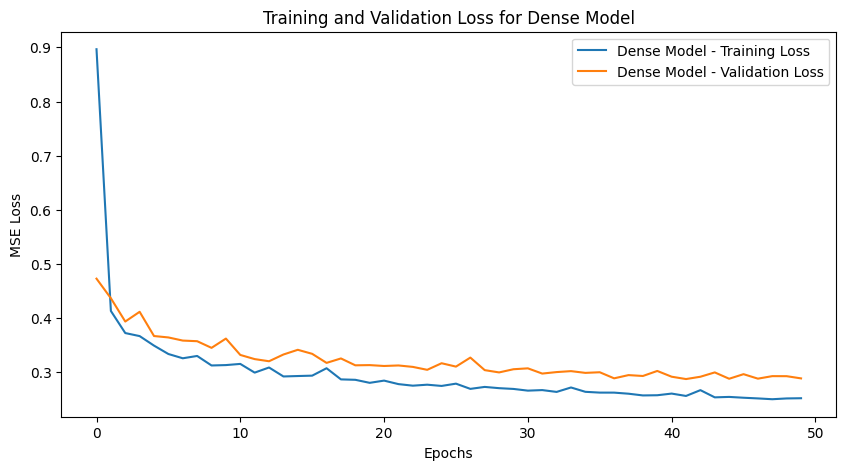

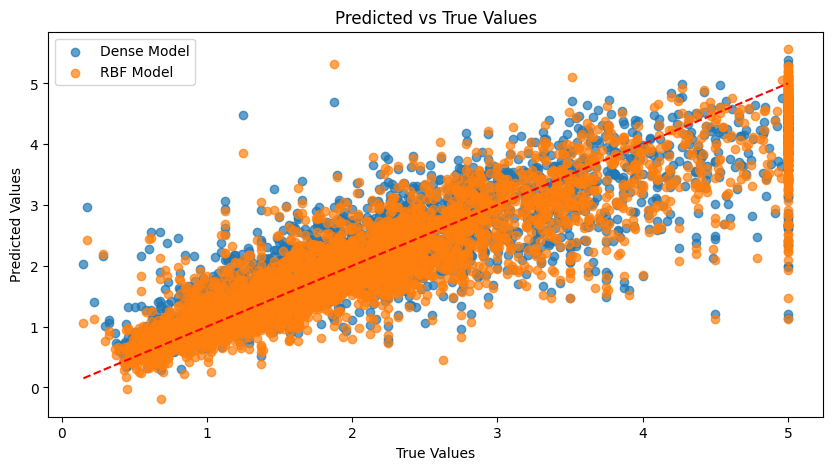

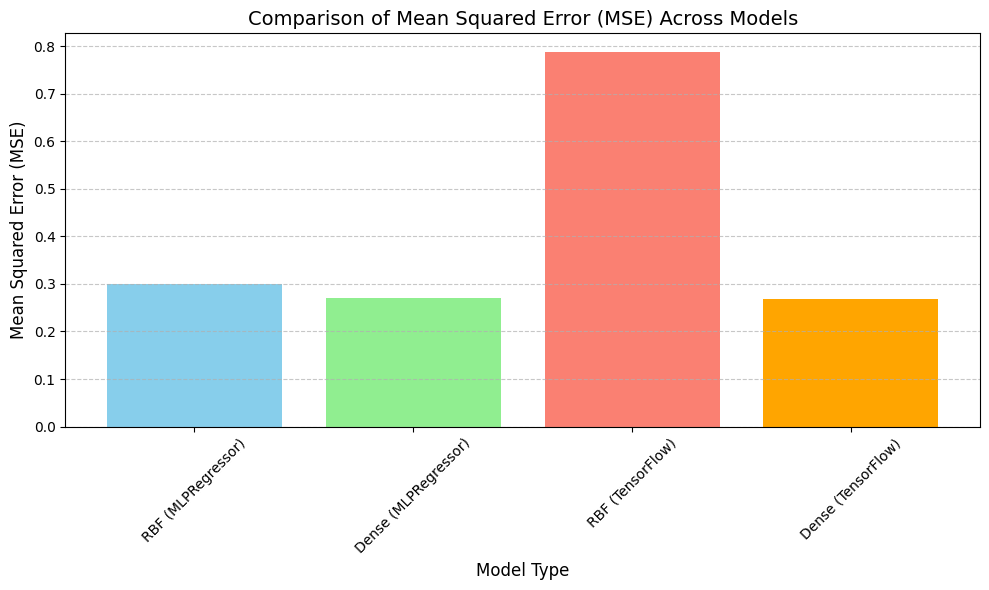

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_dense.history['loss'], label='Dense Model - Training Loss')
plt.plot(history_dense.history['val_loss'], label='Dense Model - Validation Loss')
plt.title('Training and Validation Loss for Dense Model')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_dense, alpha=0.7, label='Dense Model')
plt.scatter(y_test, y_pred_rbf, alpha=0.7, label='RBF Model')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# نتایج MSE برای مدل‌ها
mse_results = {
    "RBF (MLPRegressor)": 0.300056390009458,
    "Dense (MLPRegressor)":0.27099387608468906,
    "RBF (TensorFlow)": 0.7872895002365112,
    "Dense (TensorFlow)": 0.26767823100090027,
}

# رسم نمودار میله‌ای برای مقایسه MSE
plt.figure(figsize=(10, 6))
plt.bar(
    x=mse_results.keys(),  # برچسب مدل‌ها
    height=mse_results.values(),  # مقادیر MSE
    color=['skyblue', 'lightgreen', 'salmon', 'orange']  # رنگ‌های متفاوت برای هر مدل
)
# تنظیمات عنوان و برچسب‌های محورها
plt.title("Comparison of Mean Squared Error (MSE) Across Models", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
plt.xlabel("Model Type", fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # چرخش و اندازه فونت برچسب‌ها
plt.grid(axis='y', linestyle='--', alpha=0.7)  # اضافه کردن خطوط شبکه برای محور y
plt.tight_layout()  # تنظیم چیدمان نمودار
plt.show()

